In [80]:
!pip install torch pandas numpy matplotlib nltk

In [81]:
import string
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
from nltk.corpus import stopwords
import unidecode
import time

In [82]:
!pip install requests

In [83]:
import requests

In [84]:
data = requests.get('https://gist.githubusercontent.com/aryanshridhar/3f90fdf6676ce54b63fd6f165e569ec9/raw/fcf76b36cb75cf4750251bdf4e726807b1d5baa6/Data.txt')
data = str(data.text)

In [85]:
data = re.sub('\n' , ' ' , data)

In [86]:
torch.cuda.is_available()

True

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
all_chars = string.printable
print(all_chars)
print(len(all_chars))

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

100


In [89]:
class TextPreprocessing:
    def __init__(self , text):
        self.text = text
        self.text = unidecode.unidecode(self.text)
        self.text = re.sub(' +',' ', self.text)

In [90]:
t1 = TextPreprocessing(data)

In [91]:
text = t1.text

In [92]:
len(text)

770220

In [93]:
class CharGenRNN(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , n_layers):
        
        super(CharGenRNN , self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(self.input_size, self.hidden_size)
        self.rnn = nn.LSTM(self.hidden_size , 
                           self.hidden_size , 
                           self.n_layers , 
                           batch_first = True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
   
    def forward(self , batch):
        batch = batch.long()
        out = self.embedding(batch)
        out , _ = self.rnn(out)
        out = self.linear(out)
        
        return out

In [100]:
class Generation:
    def __init__(self , text , all_chars):
        
        self.seq_len = 256 # predicting next character form the previous 32 characters
        self.batch_size = 126 # total of 16 , 32 seq in a batch
        
        self.all_chars = {j:i for i,j in enumerate(all_chars)}
        self.reverse_chars = {i:j for i,j in enumerate(all_chars)}
        
        self.text = text[:-(len(text) % (self.seq_len * self.batch_size))]

        self.input_size = len(all_chars)
        self.hidden_size = 256
        self.output_size = self.input_size
        self.n_layers = 2
        self.epochs = 1000
        self.print_every = 10
        self.generate_every = 100
        self.lr = 0.01
        
        self.rnn = CharGenRNN(self.input_size , 
                              self.hidden_size , 
                              self.output_size , 
                              self.n_layers).to(device)
        

    def get_batches(self):
        
        i = 0
        counter = 0    
        no_time = len(self.text) // (self.seq_len * self.batch_size)
        encoded_text = list(map(lambda x : self.all_chars[x] , self.text))
        
        while i != int(no_time)-1:
            
            x_list = []
            y_seq = []
            
            for _ in range(self.batch_size):
                x_list.append(encoded_text[counter:self.seq_len+counter])
                y_seq.append(encoded_text[counter + 1:self.seq_len+counter+1])
                counter += self.seq_len
            
            i += 1
            yield x_list,y_seq
            
            
    def show_batches(self):
        for i,j in self.get_batches():
            i , j = torch.Tensor(i).long() , torch.Tensor(j).long()
            print(i)
            print(j)
            break
            
    def init_loss(self):
        
        self.criterion = nn.CrossEntropyLoss()
        
        for epoch in range(self.epochs):
            for label,actual in self.get_batches():
                    
                label = torch.Tensor(label).float().to(device)
                actual = torch.Tensor(actual).long().to(device)
            
                y_pred = self.rnn(label)
                y_pred = y_pred.transpose(1,2)
                loss = self.criterion(y_pred,actual)
                
                print(loss.item())
                break
            break
            
    def train(self):
        
        time1 = time.time()
        
        self.iterations = []
        self.loss_ = []
        
        self.criterion = nn.CrossEntropyLoss()
        
        self.optimizer = optim.Adam(self.rnn.parameters() , lr = self.lr)
        
        for epoch in range(self.epochs):
            for label,actual in self.get_batches():

                    
                label = torch.Tensor(label).float().to(device)
                actual = torch.Tensor(actual).long().to(device)
            
                y_pred = self.rnn(label)
                y_pred = y_pred.transpose(1,2)
                
                loss = self.criterion(y_pred,actual)
                
                loss.backward()
                
                with torch.no_grad():
                    
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    
            self.iterations.append(epoch)
            self.loss_.append(loss)
            
            if epoch % self.print_every == 0:
                print(f"Loss after {epoch} iteration : {loss}")
                
            if epoch % self.generate_every == 0:
                final = time.time() - time1
                print(f"Time elapsed : {round(final , 2)} seconds")
                print(f"Generated Text after {epoch} epoch : {self.generate_text()}\n")
                
                
        self.show_plot(self.iterations , self.loss_)
                
                
    def show_plot(self,x,y):
        plt.plot(x,y)
        plt.xlabel('Epoch/Iteration')
        plt.ylabel('Loss')
        plt.show()
        
    
    def generate_text(self , init_str = 'Hello Everybody , I am ',predict_len = 200):
        
        generated_list = [w for w in init_str]
        
        for _ in range(predict_len):
            
            tensor = torch.Tensor([self.all_chars[generated_list[-1].lower()]]).long().unsqueeze(0)
            out = self.rnn(tensor.to(device))
            prob = F.softmax(out.squeeze() , dim = 0)
            
            value , ind = torch.topk(prob , 3)
            index = np.random.choice(ind.tolist())
    
            char = self.reverse_chars[index]
            
            generated_list.append(char)
            
        return ''.join(generated_list)


In [101]:
g1 = Generation(text , all_chars)

In [102]:
g1.show_batches()

tensor([[44, 29, 94,  ..., 25, 14, 73],
        [94, 18, 29,  ..., 29, 18, 14],
        [28, 94, 18,  ..., 15, 10, 12],
        ...,
        [13, 94, 10,  ..., 28, 14, 10],
        [75, 94, 36,  ..., 94, 21, 10],
        [27, 16, 14,  ..., 17, 94, 22]])
tensor([[29, 94, 32,  ..., 14, 73, 94],
        [18, 29, 94,  ..., 18, 14, 28],
        [94, 18, 23,  ..., 10, 12, 14],
        ...,
        [94, 10, 29,  ..., 14, 10, 75],
        [94, 36, 94,  ..., 21, 10, 27],
        [16, 14, 94,  ..., 94, 22, 18]])


In [103]:
g1.init_loss()

4.605172634124756


Loss after 0 iteration : 2.937901258468628
Time elapsed : 3.97 seconds
Generated Text after 0 epoch : Hello Everybody , I am he teenott ateee ht t t a aateeenee hteneneeeeeen a ht t h a h a aat tt htt htee ht ttt aaaa te tt a ttttte htt t aat hteen atte t htt ttt att at a att ateee ate te tteeene hen ttteee ht a te h ht ht 

Loss after 10 iteration : 1.8760370016098022
Loss after 20 iteration : 1.6069384813308716
Loss after 30 iteration : 1.4725595712661743
Loss after 40 iteration : 1.4013361930847168
Loss after 50 iteration : 1.3411526679992676
Loss after 60 iteration : 1.3060766458511353
Loss after 70 iteration : 1.2838151454925537
Loss after 80 iteration : 1.2572195529937744
Loss after 90 iteration : 1.2362011671066284
Loss after 100 iteration : 1.2250741720199585
Time elapsed : 382.86 seconds
Generated Text after 100 epoch : Hello Everybody , I am anene athas thedonene to t athist aned,, sen athedoup se stoutonedo t ase thathed,,,"Llit athist s as s ane sed sened athat and s s s s 

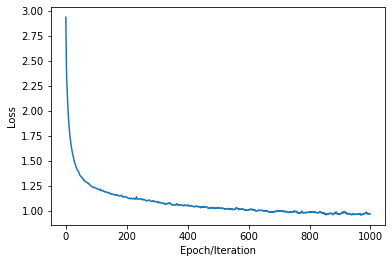

In [104]:
g1.train()

In [105]:
g1.generate_text(predict_len = 1000)

'Hello Everybody , I am thane t on an athis,se onere ore oned on ore tore touthas oner as,"D atoure t at and torthit orere as,sed athed, as ane t ous ator orer as onert t t oner anedous thathis, athas tous as toredor tondor thed, t tortond ased, aton on ored,se on orert ase on one orthe t andouthas,s,"D tond ous," out an one athat thathis ous, tout thiner at thinered,sere thit ond, athere athandore outor orthind,s," out thise on ourtous, and, at aser outourtout t an anere andousedorthed as or andor t an anered oned," orthere outortorer tone t ond tonerertoredortond,"Ld," ond,sed, t ore ous, asert an or orer t as ator t thasere ortor an ored at thiser tondouthe ort ton one ored,"D thiser t t tort our ous,se orered, at ased outhandond than ous, orthan at ase that andortort ane as and ase aserer t t aser orer ase oner t t t ored, t at at t and,s aned," ase and,se onedoure t t and ator as t tone at at t outoured tor thathase tourthe t an thas," t ort atortone ase as ond,"Lllld on tone that